In [149]:
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# handling missing values
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBModel

# handle outliers
from sklearn.ensemble import IsolationForest

# feature encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# model selection
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import RandomizedSearchCV

# hyper-parameter tuning 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from itertools import product

from util import plotter, cat_plotter

In [4]:
import warnings
warnings.filterwarnings('ignore') 

pd.options.display.max_columns = 40

# Objectives

# Loading Data

In [5]:
df = pd.read_csv("./kidney_disease.csv")
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,bu,sc,sod,pot,hemo,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


In [6]:
# rename the columns
columns = ['id', 'age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
              'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
              'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
              'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema',
              'aanemia', 'class']
df.columns = columns
df.head()


,id,age,blood_pressure,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose_random,blood_urea,serum_creatinine,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class
0,0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,36.0,1.2,NaN,NaN,15.4,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,18.0,0.8,NaN,NaN,11.3,38,6000,NaN,no,no,no,good,no,no,ckd
2,2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,53.0,1.8,NaN,NaN,9.6,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,56.0,3.8,111.0,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,26.0,1.4,NaN,NaN,11.6,35,7300,4.6,no,no,no,good,no,no,ckd


# Data Preprocessing

#### fixing some problmes in dataset  

In [7]:
df = df.drop(columns=["id"])

for this you could also use `replace` :
```python
    df[feature].replace(
        {
            "\t?": np.nan
        }
    )
```

In [8]:
# one wired thing is that there is a value \t? in one of the columns, and we should fix it...
faulty_columns = ["packed_cell_volume", "white_blood_cell_count", "red_blood_cell_count"]
for column in faulty_columns :
    index = df[column].where(df[column] == "\t?").dropna().index[0]
    df[column][index] = np.nan

df[faulty_columns] = df[faulty_columns].astype("float") # fixing their dtype

In [9]:
# the values in this column look like this which should be fiexed
# no       258
# yes      134
# \tno       3
# \tyes      2
#  yes       1
 
index = df["diabetes_mellitus"].where(df["diabetes_mellitus"] == "\tno").dropna().index
df["diabetes_mellitus"][index] = "no"

index = df["diabetes_mellitus"].where(df["diabetes_mellitus"] == "\tyes").dropna().index
df["diabetes_mellitus"][index] = "yes"

index = df["diabetes_mellitus"].where(df["diabetes_mellitus"] == " yes").dropna().index
df["diabetes_mellitus"][index] = "yes"

In [10]:
# coronary_artery_disease
# no      362
# yes      34
# \tno      2

index = df["coronary_artery_disease"].where(df["coronary_artery_disease"] == "\tno").dropna().index
df["coronary_artery_disease"][index] = "no"

In [11]:
# class
# ckd       248
# notckd    150
# ckd\t       2

index = df["class"].where(df["class"] == "ckd\t").dropna().index
df["class"][index] = "ckd"

## fixing null values

In [12]:
df.isnull().sum()

age                          9
blood_pressure              12
specific_gravity            47
albumin                     46
sugar                       49
red_blood_cells            152
pus_cell                    65
pus_cell_clumps              4
bacteria                     4
blood_glucose_random        44
blood_urea                  19
serum_creatinine            17
sodium                      87
potassium                   88
haemoglobin                 52
packed_cell_volume          71
white_blood_cell_count     106
red_blood_cell_count       131
hypertension                 2
diabetes_mellitus            2
coronary_artery_disease      2
appetite                     1
peda_edema                   1
aanemia                      1
class                        0
dtype: int64

#### examining some of the columns **Distribution** and their **BoxPlot**

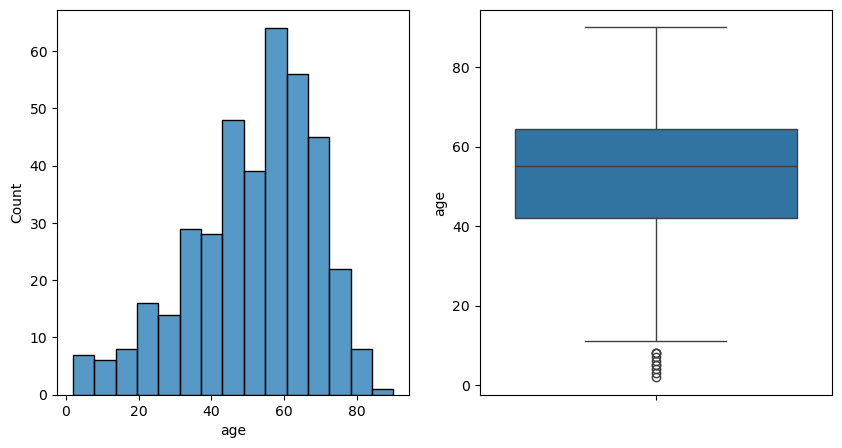

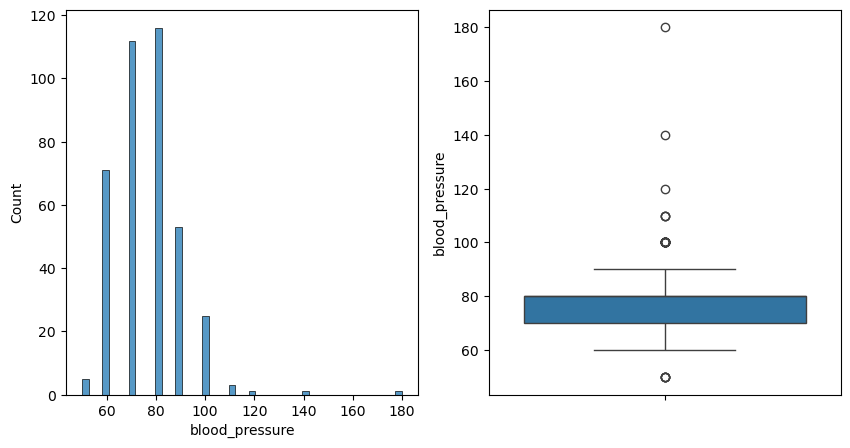

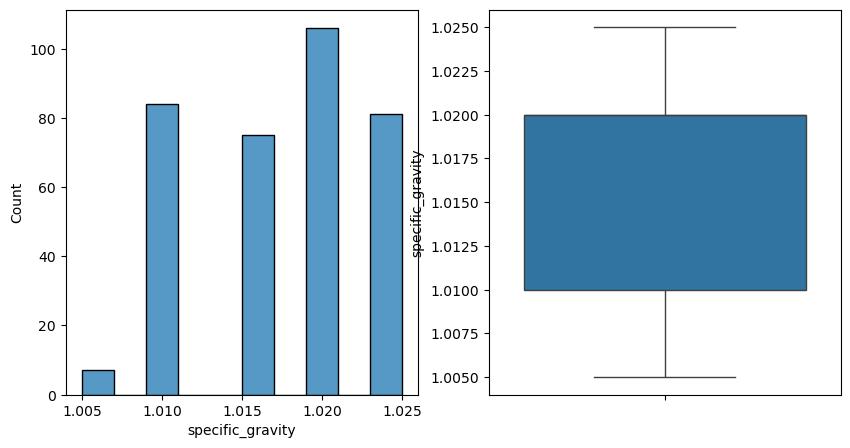

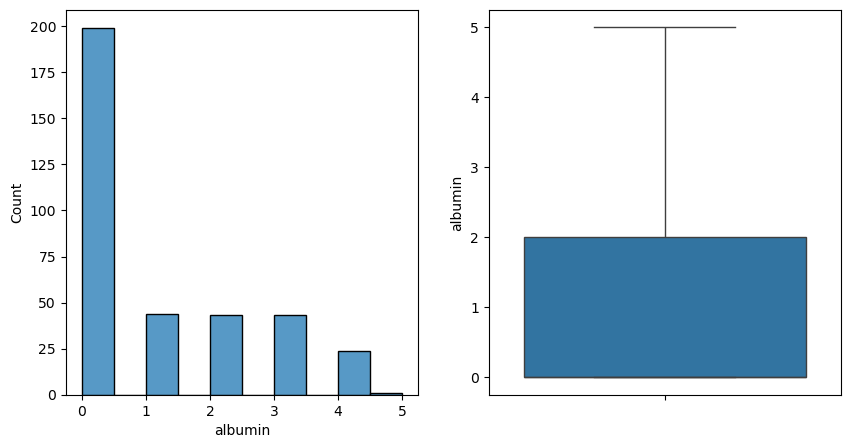

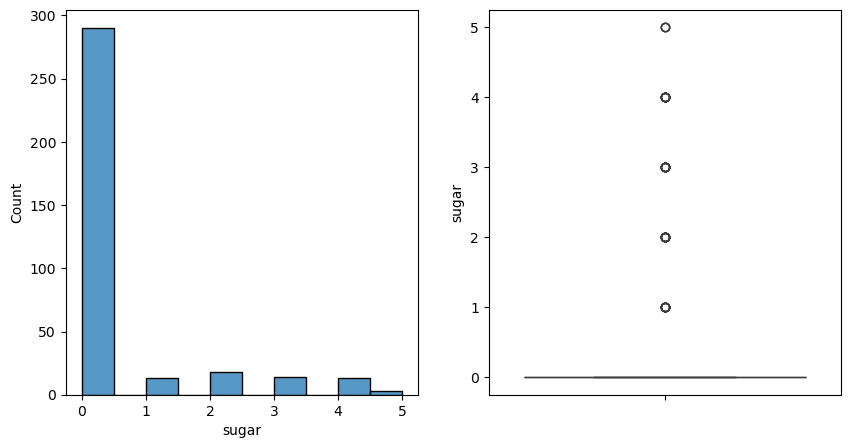

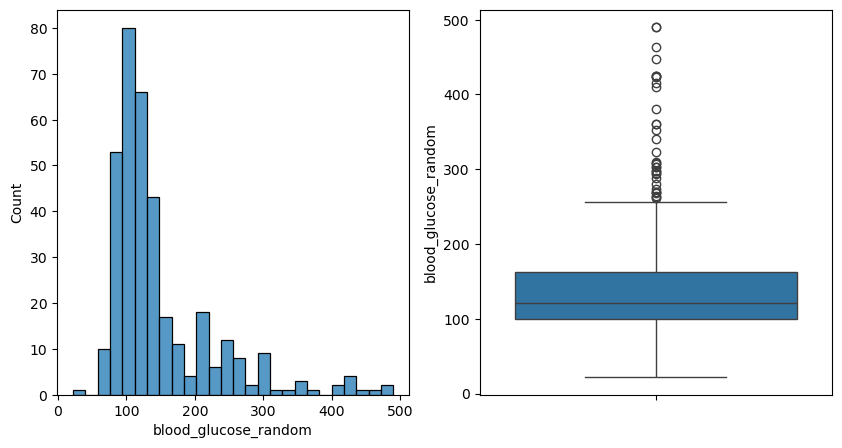

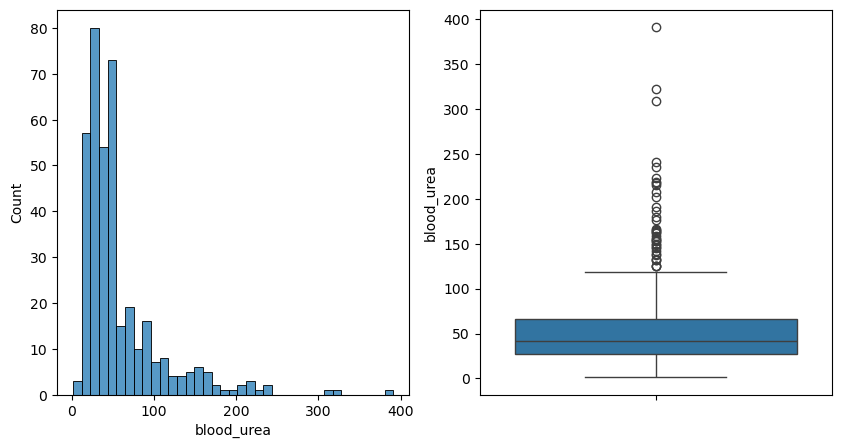

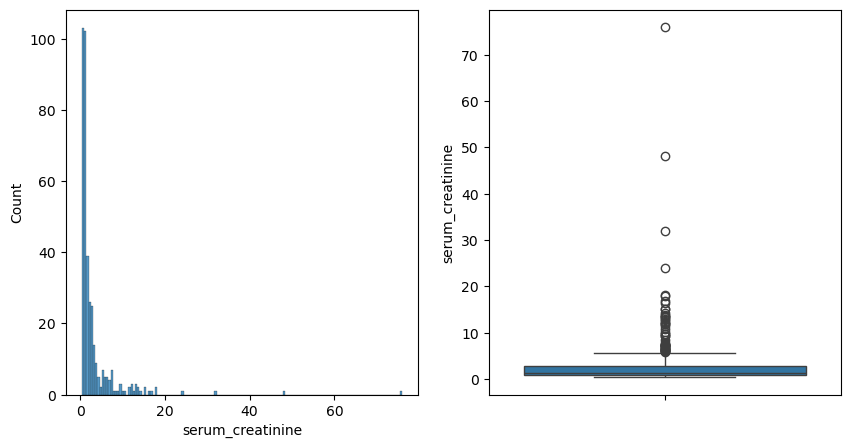

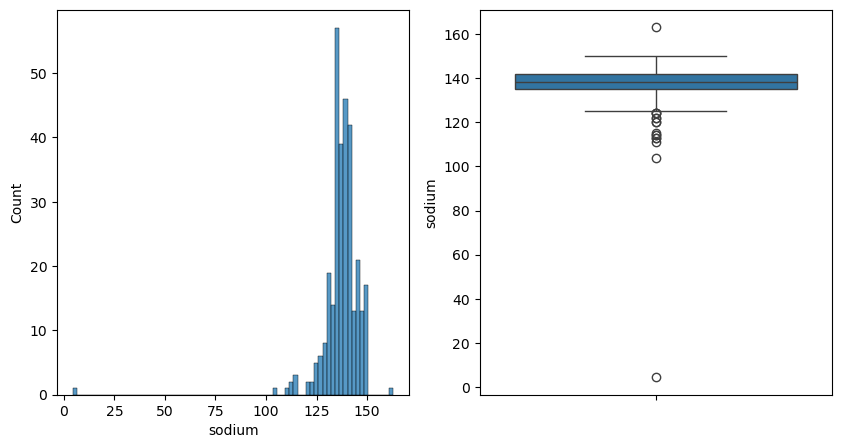

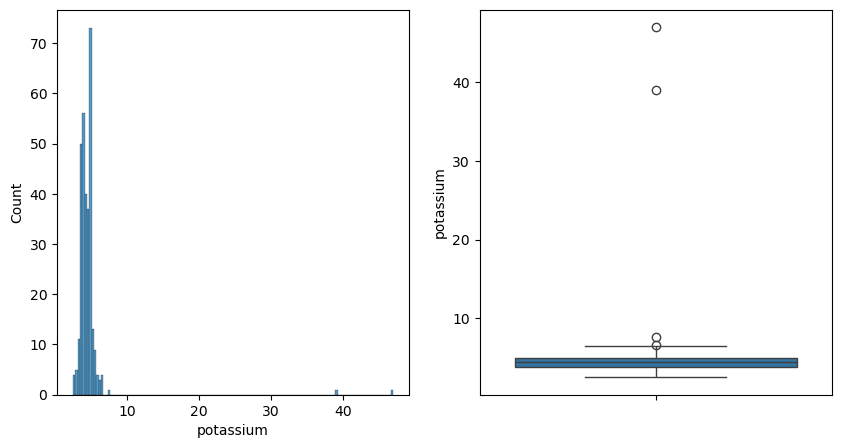

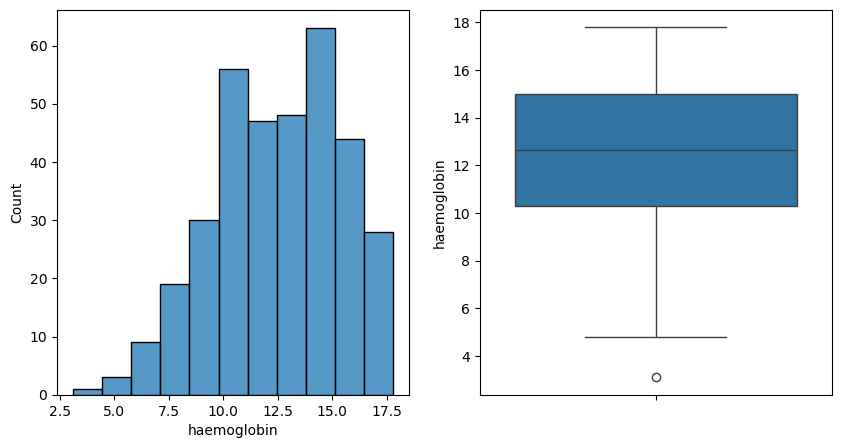

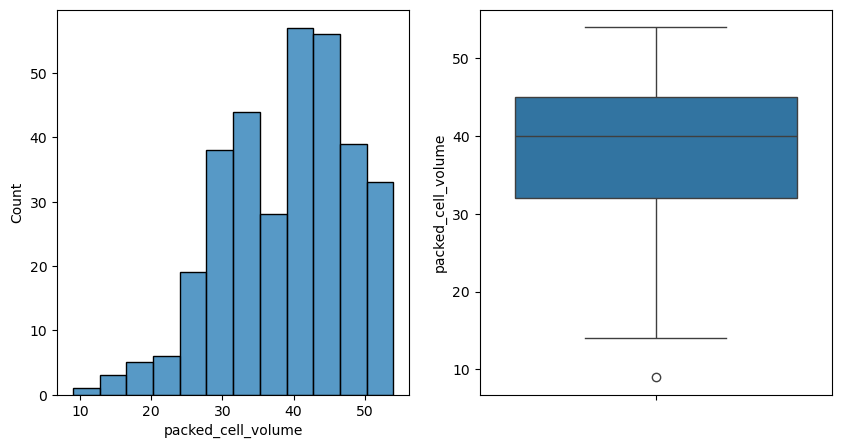

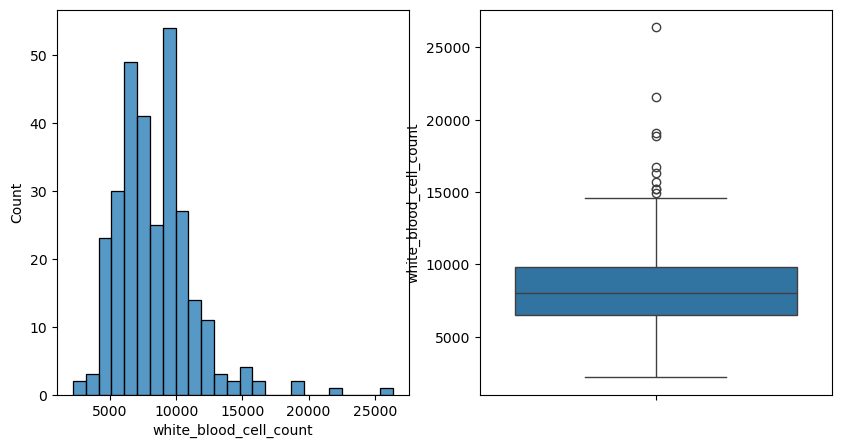

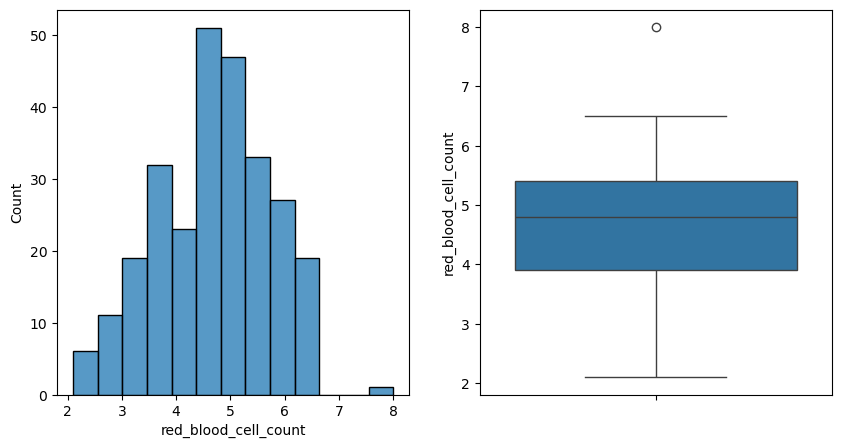

In [13]:
numeric_features = df.select_dtypes(["int", "float"]).columns.to_numpy()

for column in numeric_features :
    plotter(df, column)


**after this noticed that `sugar` and `albumin` are *categorical* data**

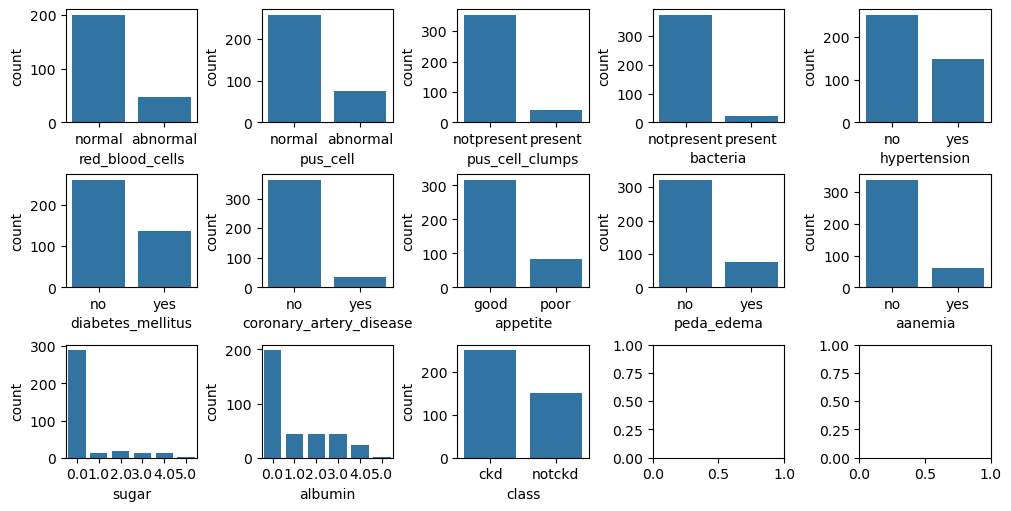

In [14]:
cat_features = ['red_blood_cells', 'pus_cell', 'pus_cell_clumps', 'bacteria',
       'hypertension', 'diabetes_mellitus', 'coronary_artery_disease',
       'appetite', 'peda_edema', 'aanemia', 'sugar', 'albumin', 'class']

fig_x = 3
fig_y = 5

fig, axes = plt.subplots(fig_x, fig_y, figsize=(10, 5), layout="constrained")

for index, column in zip(product(range(fig_x), range(fig_y)), cat_features) :
    cat_plotter(df, column, ax=axes[index[0], index[1]])

plt.show()


#### Imputation

In [15]:
# using Iterative Imputer
def IterativeImputerFunc(df, features, **kwargs) :
    imputer = IterativeImputer(**kwargs)
    imputed_feature = imputer.fit_transform(df.select_dtypes(["int", "float"]))
    return imputed_feature

In [16]:
# using KNN imputer
def KNNImputerFunc(df, feature: str, **kwargs) :
    KNN_imputer = KNNImputer(n_neighbors=5, **kwargs)
    KNN_imputed_feature = KNN_imputer.fit_transform(df[feature].to_numpy().reshape(-1, 1))
    return KNN_imputed_feature

#### appling null value fixing methods

In [17]:
features = [
    "blood_glucose_random", "blood_urea", "sodium", "potassium", "haemoglobin",
    "packed_cell_volume", "white_blood_cell_count", "red_blood_cell_count", "serum_creatinine"
]

In [18]:
values = IterativeImputerFunc(df, features) # new values for columns that have Nan in them
tmp = df.select_dtypes(["int", "float"]).copy() # a tmp dataframe to store new values in it
tmp[:] = values
df = df.drop(columns=features) # dropping the features so that we can replace them later
df[features] = tmp[features]

for some reasons they both set the `mean()` for all values ...

In [19]:
# replacing these features with their mode
for feature in ["age"] :
    filler = df[feature].mode()[0]
    df[feature] = df[feature].fillna(filler)

In [20]:
# replacing categorical data's missing values with their top n values
features = [
    ("blood_pressure", 5),
    ("specific_gravity", 4),
    ("albumin", 5),
    ("sugar", 5),
    ("pus_cell", 2),
    ("pus_cell_clumps", 2),
    ("bacteria", 2),
    ("hypertension", 2),
    ('diabetes_mellitus', 2),
    ('coronary_artery_disease', 2),
    ('appetite', 2),
    ('peda_edema', 2),
    ('aanemia', 2),
]


for feature_name, group_count in features : 
    group_chance = df[feature_name].value_counts() / df[feature_name].value_counts().sum()
    group_chance = group_chance.sort_values(ascending=False).iloc[0:group_count]
    group_chance /= group_chance.sum() # normalize the data so that the values sum up to 1.0

    group_names = group_chance.index

    nan_index = df[feature_name][df[feature_name].isna()].index
    values = np.random.choice(
        group_names,
        size=len(nan_index),
        p=group_chance,
    )

    values = pd.Series( # convert the values to a series
        values,
        index=nan_index
    )

    df[feature_name] = df[feature_name].fillna(values)

In [21]:
# drop some of the features with many null values 
columns = ["red_blood_cells", ]
df = df.drop(columns=columns)

The other way you can fill the Nan values is by getting **samples** from the non-Nan values in that column, and fill the Nan values with them

In [22]:
df.isna().sum()

age                        0
blood_pressure             0
specific_gravity           0
albumin                    0
sugar                      0
pus_cell                   0
pus_cell_clumps            0
bacteria                   0
hypertension               0
diabetes_mellitus          0
coronary_artery_disease    0
appetite                   0
peda_edema                 0
aanemia                    0
class                      0
blood_glucose_random       0
blood_urea                 0
sodium                     0
potassium                  0
haemoglobin                0
packed_cell_volume         0
white_blood_cell_count     0
red_blood_cell_count       0
serum_creatinine           0
dtype: int64

## Fixing dtypes

In [23]:
df.dtypes

age                        float64
blood_pressure             float64
specific_gravity           float64
albumin                    float64
sugar                      float64
pus_cell                    object
pus_cell_clumps             object
bacteria                    object
hypertension                object
diabetes_mellitus           object
coronary_artery_disease     object
appetite                    object
peda_edema                  object
aanemia                     object
class                       object
blood_glucose_random       float64
blood_urea                 float64
sodium                     float64
potassium                  float64
haemoglobin                float64
packed_cell_volume         float64
white_blood_cell_count     float64
red_blood_cell_count       float64
serum_creatinine           float64
dtype: object

In [24]:
# to get the columns that have only int values 
df.select_dtypes("float").apply(
    lambda column: column.apply(
            lambda value: value.is_integer(),
        ),
    axis=1
).all()

age                        True
blood_pressure             True
specific_gravity          False
albumin                    True
sugar                      True
blood_glucose_random      False
blood_urea                False
sodium                    False
potassium                 False
haemoglobin               False
packed_cell_volume        False
white_blood_cell_count    False
red_blood_cell_count      False
serum_creatinine          False
dtype: bool

In [25]:
df.select_dtypes(exclude=["int", "float"]).value_counts()

pus_cell  pus_cell_clumps  bacteria    hypertension  diabetes_mellitus  coronary_artery_disease  appetite  peda_edema  aanemia  class 
normal    notpresent       notpresent  no            no                 no                       good      no          no       notckd    144
                                                                                                                                ckd        30
                                       yes           yes                no                       good      no          no       ckd        21
                                       no            yes                no                       good      no          no       ckd        12
                                       yes           yes                no                       poor      yes         no       ckd         9
                                                                                                                                         ... 
abnormal  pre

In [26]:
# fixing dtypes
df.astype(
    {
        "age": int,
        "blood_pressure": int,
        "albumin": int,  # after checking the visualizations, i found that it is categorical data 
        "sugar": int,  # after checking the visualizations, i found that it is categorical data
        "pus_cell": "category",
        "pus_cell_clumps": "category",
        "bacteria": "category",
        "appetite": "category",
    }
)

,age,blood_pressure,specific_gravity,albumin,sugar,pus_cell,pus_cell_clumps,bacteria,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class,blood_glucose_random,blood_urea,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,serum_creatinine
0,48,80,1.020,1,0,normal,notpresent,notpresent,yes,yes,no,good,no,no,ckd,121.000000,36.0,139.737294,4.191305,15.4,44.0,7800.0,5.200000,1.2
1,7,50,1.020,4,0,normal,notpresent,notpresent,no,no,no,good,no,no,ckd,149.230278,18.0,130.969237,3.404036,11.3,38.0,6000.0,4.637296,0.8
2,62,80,1.010,2,3,normal,notpresent,notpresent,no,yes,no,poor,no,yes,ckd,423.000000,53.0,132.670950,4.816729,9.6,31.0,7500.0,3.783108,1.8
3,48,70,1.005,4,0,abnormal,present,notpresent,yes,no,no,poor,yes,yes,ckd,117.000000,56.0,111.000000,2.500000,11.2,32.0,6700.0,3.900000,3.8
4,51,80,1.010,2,0,normal,notpresent,notpresent,no,no,no,good,no,no,ckd,106.000000,26.0,135.843529,3.739053,11.6,35.0,7300.0,4.600000,1.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55,80,1.020,0,0,normal,notpresent,notpresent,no,no,no,good,no,no,notckd,140.000000,49.0,150.000000,4.900000,15.7,47.0,6700.0,4.900000,0.5
396,42,70,1.025,0,0,normal,notpresent,notpresent,no,no,no,good,no,no,notckd,75.000000,31.0,141.000000,3.500000,16.5,54.0,7800.0,6.200000,1.2
397,12,80,1.020,0,0,normal,notpresent,notpresent,no,no,no,good,no,no,notckd,100.000000,26.0,137.000000,4.400000,15.8,49.0,6600.0,5.400000,0.6
398,17,60,1.025,0,0,normal,notpresent,notpresent,no,no,no,good,no,no,notckd,114.000000,50.0,135.000000,4.900000,14.2,51.0,7200.0,5.900000,1.0


to fix the boolean features which are :

hypertension  
diabetes_mellitus  
coronary_artery_disease  
peda_edema  
aanemia  
class  

In [27]:
# we can use label encoder :
cols_to_encode = ["hypertension", "diabetes_mellitus", "coronary_artery_disease", "peda_edema", "aanemia", 'class']
encoder = LabelEncoder()
for column in cols_to_encode :
    df[column] = encoder.fit_transform(df[column])


In [28]:
df.head()

,age,blood_pressure,specific_gravity,albumin,sugar,pus_cell,pus_cell_clumps,bacteria,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class,blood_glucose_random,blood_urea,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,serum_creatinine
0,48.0,80.0,1.020,1.0,0.0,normal,notpresent,notpresent,1,1,0,good,0,0,0,121.000000,36.0,139.737294,4.191305,15.4,44.0,7800.0,5.200000,1.2
1,7.0,50.0,1.020,4.0,0.0,normal,notpresent,notpresent,0,0,0,good,0,0,0,149.230278,18.0,130.969237,3.404036,11.3,38.0,6000.0,4.637296,0.8
2,62.0,80.0,1.010,2.0,3.0,normal,notpresent,notpresent,0,1,0,poor,0,1,0,423.000000,53.0,132.670950,4.816729,9.6,31.0,7500.0,3.783108,1.8
3,48.0,70.0,1.005,4.0,0.0,abnormal,present,notpresent,1,0,0,poor,1,1,0,117.000000,56.0,111.000000,2.500000,11.2,32.0,6700.0,3.900000,3.8
4,51.0,80.0,1.010,2.0,0.0,normal,notpresent,notpresent,0,0,0,good,0,0,0,106.000000,26.0,135.843529,3.739053,11.6,35.0,7300.0,4.600000,1.4


## EDA

- correlation
- violin plot

## Handling Outliers

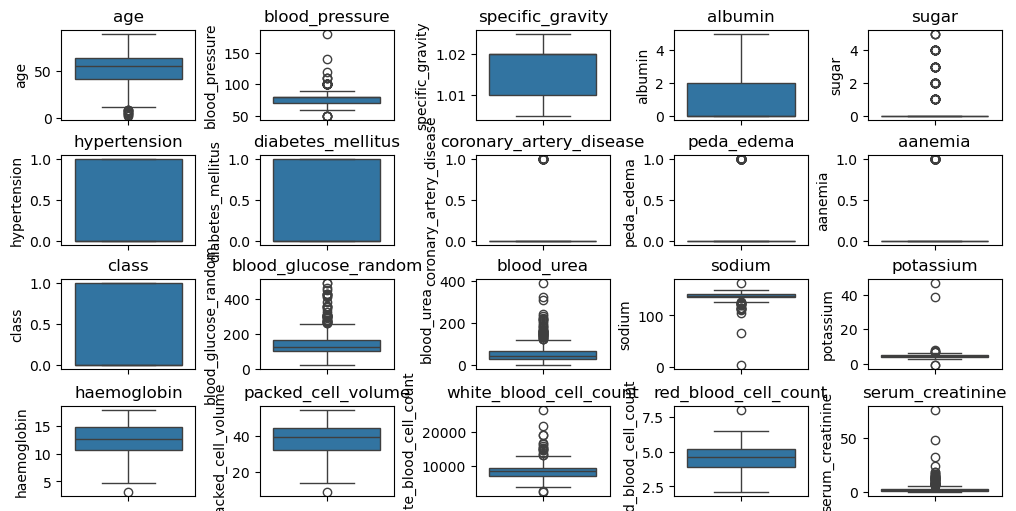

In [29]:
fig_x = 4
fig_y = 5
fig, axes = plt.subplots(fig_x, fig_y, figsize=(10, 5), layout="constrained")

for index, column in zip(product(range(fig_x), range(fig_y)), df.select_dtypes(["int", "float", "bool"])) :
    sns.boxplot(
        df[column],
        ax=axes[index[0], index[1]],
    )
    axes[index[0], index[1]].set_title(column)

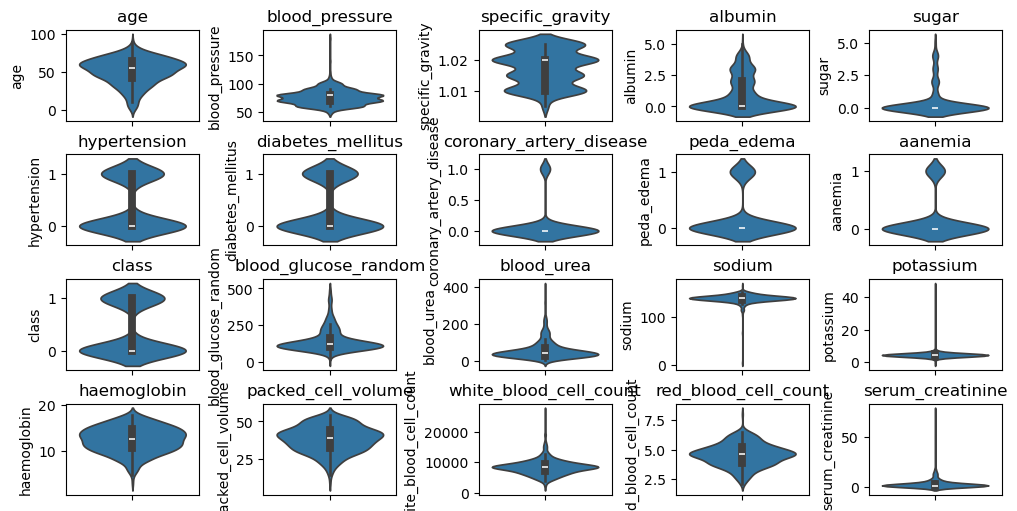

In [30]:
fig_x = 4
fig_y = 5
fig, axes = plt.subplots(fig_x, fig_y, figsize=(10, 5), layout="constrained")

for index, column in zip(product(range(fig_x), range(fig_y)), df.select_dtypes(["int", "float", "bool"])) :
    sns.violinplot(
        df[column],
        ax=axes[index[0], index[1]],
    )
    axes[index[0], index[1]].set_title(column)

In [31]:
df["class"].value_counts()

class
0    250
1    150
Name: count, dtype: int64

##### method 1:  `IsolationForest`

In [32]:
def box_plotter(df, features=None) :
    fig_x = 3
    fig_y = 5
    fig, axes = plt.subplots(fig_x, fig_y, figsize=(10, 5), layout="constrained")
    df = df.select_dtypes(["int", "float"]) if features==None else df.select_dtypes(["int", "float"])[features]
    for index, column in zip(product(range(fig_x), range(fig_y)), df) :
        sns.boxplot(
            df[column],
            ax=axes[index[0], index[1]],
        )
        axes[index[0], index[1]].set_title(column)

In [33]:
def single_outlier_removal(column: pd.DataFrame, n_estimators=20, contamination=0.05) :
    # single feature
    isolation_forest =IsolationForest(n_estimators=n_estimators, max_samples='auto', contamination=contamination, max_features=1)
    isolation_forest.fit(column)

    tmp_df = column.copy()
    tmp_df["anomaly"] = isolation_forest.predict(column)
    tmp_df = tmp_df.query("anomaly == 1")
    tmp_df.drop(columns="anomaly", inplace=True)
    return tmp_df

In [34]:
def outlier_removal(df: pd.DataFrame, n_estimators=200, contamination=0.05) :
    # whole features
    isolation_forest =IsolationForest(n_estimators=n_estimators, max_samples='auto', contamination=contamination, max_features=1)
    isolation_forest.fit(df)

    tmp_df = df.copy()
    tmp_df["anomaly"] = isolation_forest.predict(df)
    tmp_df = tmp_df.query("anomaly == 1")
    tmp_df.drop(columns="anomaly", inplace=True)
    return tmp_df

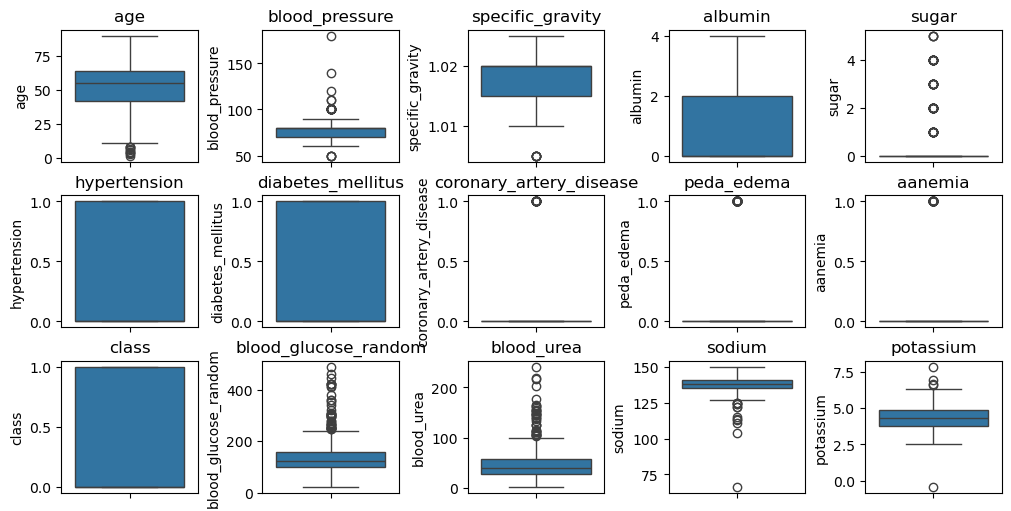

In [35]:
new = outlier_removal(df.select_dtypes(["int", "float"]), n_estimators=200)
box_plotter(new)

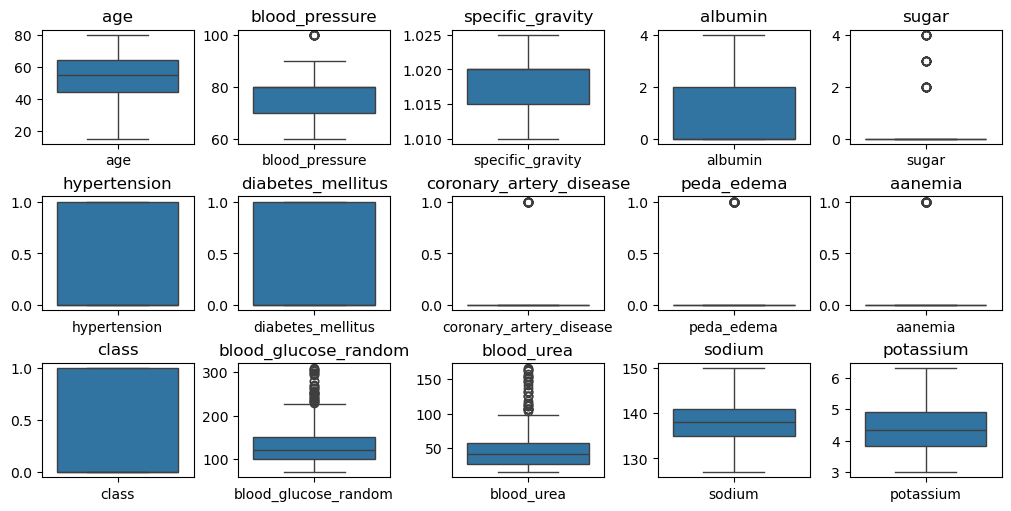

In [36]:
fig_x = 3
fig_y = 5
fig, axes = plt.subplots(fig_x, fig_y, figsize=(10, 5), layout="constrained")

for index, column in zip(product(range(fig_x), range(fig_y)), df.select_dtypes(["int", "float"])) :
    sns.boxplot(
        single_outlier_removal(df[[column]]),
        ax=axes[index[0], index[1]],
    )
    axes[index[0], index[1]].set_title(column)

one wired thing that i don't understand is that when i use `IsolationForest` for single features compared to all the features at the same time,  
the results are different , beside the fact that the `n_estimators` used in `single_outlier_removal()` is smaller than `outlier_removal()`

##### apply IsolationForest / `single_outlier_removal`

In [37]:
chosen_indexes = set()
for feature in df.select_dtypes(["int", "float"]) :
    new = single_outlier_removal(df[[feature]])
    indexes = new.index.tolist()
    chosen_indexes = set(indexes) if not chosen_indexes else chosen_indexes
    chosen_indexes = chosen_indexes.intersection(set(indexes))

In [38]:
new_df = df.iloc[list(chosen_indexes), :]
new_df

,age,blood_pressure,specific_gravity,albumin,sugar,pus_cell,pus_cell_clumps,bacteria,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class,blood_glucose_random,blood_urea,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,serum_creatinine
0,48.0,80.0,1.020,1.0,0.0,normal,notpresent,notpresent,1,1,0,good,0,0,0,121.0,36.0,139.737294,4.191305,15.4,44.0,7800.0,5.2,1.2
4,51.0,80.0,1.010,2.0,0.0,normal,notpresent,notpresent,0,0,0,good,0,0,0,106.0,26.0,135.843529,3.739053,11.6,35.0,7300.0,4.6,1.4
5,60.0,90.0,1.015,3.0,0.0,normal,notpresent,notpresent,1,1,0,good,1,0,0,74.0,25.0,142.000000,3.200000,12.2,39.0,7800.0,4.4,1.1
8,52.0,100.0,1.015,3.0,0.0,abnormal,present,notpresent,1,1,0,good,0,1,0,138.0,60.0,136.699492,4.350034,10.8,33.0,9600.0,4.0,1.9
12,68.0,70.0,1.015,3.0,1.0,normal,present,notpresent,1,1,1,poor,1,0,0,208.0,72.0,138.000000,5.800000,9.7,28.0,12200.0,3.4,2.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,36.0,80.0,1.025,0.0,0.0,normal,notpresent,notpresent,0,0,0,good,0,0,1,85.0,16.0,142.000000,4.100000,15.6,44.0,5800.0,6.3,1.1
392,57.0,80.0,1.020,0.0,0.0,normal,notpresent,notpresent,0,0,0,good,0,0,1,133.0,48.0,147.000000,4.300000,14.8,46.0,6600.0,5.5,1.2
394,50.0,80.0,1.020,0.0,0.0,normal,notpresent,notpresent,0,0,0,good,0,0,1,137.0,46.0,139.000000,5.000000,14.1,45.0,9500.0,4.6,0.8
395,55.0,80.0,1.020,0.0,0.0,normal,notpresent,notpresent,0,0,0,good,0,0,1,140.0,49.0,150.000000,4.900000,15.7,47.0,6700.0,4.9,0.5


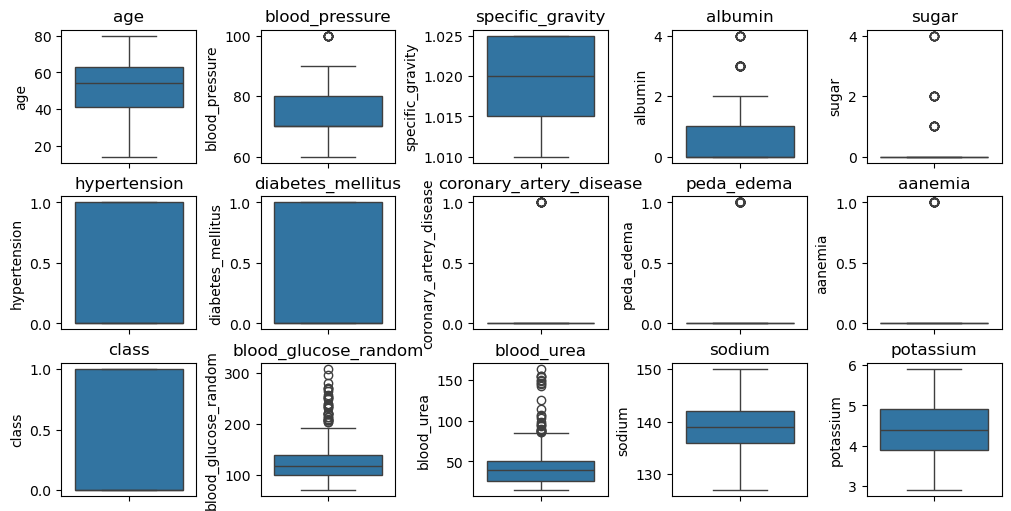

In [39]:
box_plotter(new_df)

### Handle imbalance data

## Feature Encoding

we have already handled some encodings in fixing-dtypes section, now let's do the rest ...

In [40]:
df.head()

,age,blood_pressure,specific_gravity,albumin,sugar,pus_cell,pus_cell_clumps,bacteria,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class,blood_glucose_random,blood_urea,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,serum_creatinine
0,48.0,80.0,1.020,1.0,0.0,normal,notpresent,notpresent,1,1,0,good,0,0,0,121.000000,36.0,139.737294,4.191305,15.4,44.0,7800.0,5.200000,1.2
1,7.0,50.0,1.020,4.0,0.0,normal,notpresent,notpresent,0,0,0,good,0,0,0,149.230278,18.0,130.969237,3.404036,11.3,38.0,6000.0,4.637296,0.8
2,62.0,80.0,1.010,2.0,3.0,normal,notpresent,notpresent,0,1,0,poor,0,1,0,423.000000,53.0,132.670950,4.816729,9.6,31.0,7500.0,3.783108,1.8
3,48.0,70.0,1.005,4.0,0.0,abnormal,present,notpresent,1,0,0,poor,1,1,0,117.000000,56.0,111.000000,2.500000,11.2,32.0,6700.0,3.900000,3.8
4,51.0,80.0,1.010,2.0,0.0,normal,notpresent,notpresent,0,0,0,good,0,0,0,106.000000,26.0,135.843529,3.739053,11.6,35.0,7300.0,4.600000,1.4


In [41]:
# we use label encoding
df[
    ["pus_cell", "pus_cell_clumps", "bacteria", "appetite"]
].value_counts()

pus_cell  pus_cell_clumps  bacteria    appetite
normal    notpresent       notpresent  good        253
                                       poor         41
abnormal  notpresent       notpresent  good         34
                                       poor         16
          present          notpresent  poor         13
                                       good         12
normal    present          notpresent  good          7
abnormal  present          present     good          6
          notpresent       present     poor          5
                                       good          3
          present          present     poor          2
normal    notpresent       present     good          2
                                       poor          2
          present          notpresent  poor          2
                           present     good          1
                                       poor          1
Name: count, dtype: int64

these features are also boolean, so we could also handle them in the previous parts

In [42]:
encoder = LabelEncoder()
for column in ["pus_cell", "pus_cell_clumps", "bacteria", "appetite"] :
    df[column] = encoder.fit_transform(df[column])

In [43]:
df.head()

,age,blood_pressure,specific_gravity,albumin,sugar,pus_cell,pus_cell_clumps,bacteria,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,peda_edema,aanemia,class,blood_glucose_random,blood_urea,sodium,potassium,haemoglobin,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,serum_creatinine
0,48.0,80.0,1.020,1.0,0.0,1,0,0,1,1,0,0,0,0,0,121.000000,36.0,139.737294,4.191305,15.4,44.0,7800.0,5.200000,1.2
1,7.0,50.0,1.020,4.0,0.0,1,0,0,0,0,0,0,0,0,0,149.230278,18.0,130.969237,3.404036,11.3,38.0,6000.0,4.637296,0.8
2,62.0,80.0,1.010,2.0,3.0,1,0,0,0,1,0,1,0,1,0,423.000000,53.0,132.670950,4.816729,9.6,31.0,7500.0,3.783108,1.8
3,48.0,70.0,1.005,4.0,0.0,0,1,0,1,0,0,1,1,1,0,117.000000,56.0,111.000000,2.500000,11.2,32.0,6700.0,3.900000,3.8
4,51.0,80.0,1.010,2.0,0.0,1,0,0,0,0,0,0,0,0,0,106.000000,26.0,135.843529,3.739053,11.6,35.0,7300.0,4.600000,1.4


## Feature Scaling

In [44]:
# Standard scaler
scaler = StandardScaler()
new_data = scaler.fit_transform(df.drop(columns="class"))
scaled_df = pd.DataFrame(
    new_data,
    columns=df.drop(columns="class").columns
)
scaled_df = pd.concat([scaled_df, df["class"]], axis=1)

## UseFull features

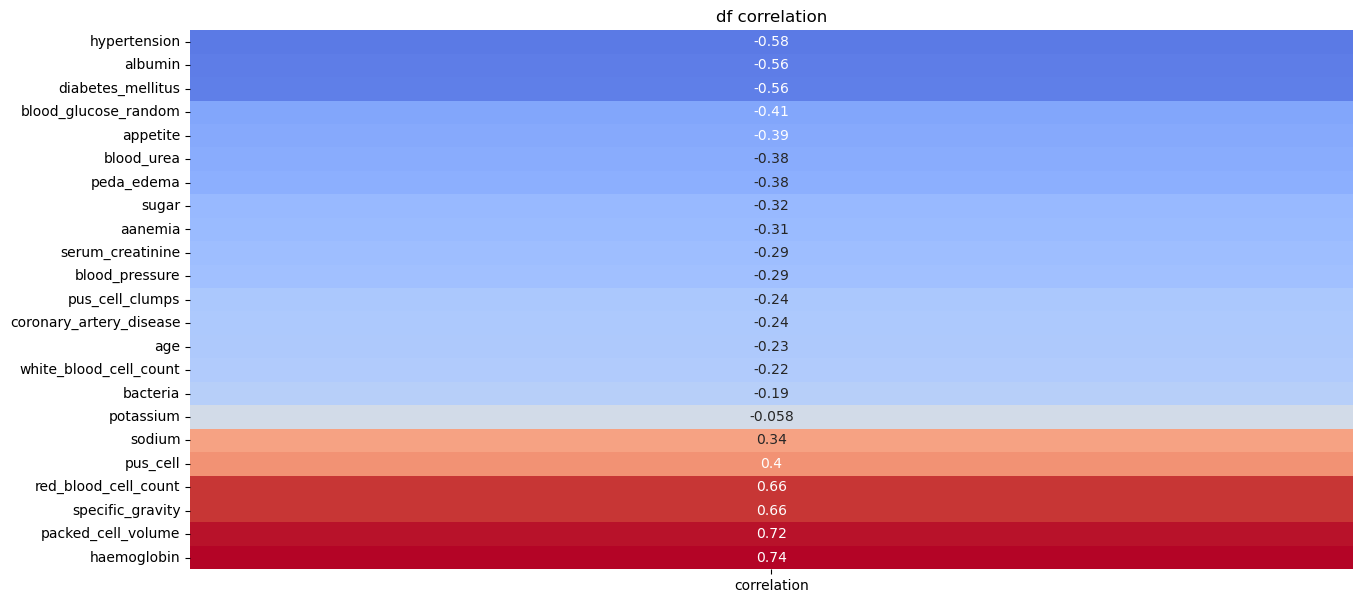

In [45]:
corr = df.drop(columns="class").corrwith(df["class"]).to_frame(name="correlation")

fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.heatmap(
    corr.sort_values(by="correlation"),
    annot=True, 
    cbar=False,
    cmap="coolwarm",
    center=0,
    ax=ax
)
ax.set_title("df correlation");

In [46]:
# without scaling
X = df.drop(columns="class")
y = df["class"]

l1_regularizer = Lasso(alpha=0.05)
selector = SelectFromModel(l1_regularizer)
selector.fit(X, y)

lasso_selected_features = X.columns[selector.get_support()]
lasso_selected_features


Index(['age', 'blood_pressure', 'albumin', 'blood_glucose_random',
       'blood_urea', 'sodium', 'haemoglobin', 'packed_cell_volume',
       'white_blood_cell_count'],
      dtype='object')

In [47]:
# another method using KBest
# for this method, the values should be non zero, so first we scale them using MinMax scaler
scaler = MinMaxScaler()
new_data = scaler.fit_transform(df.drop(columns="class"))
MinMax_scaled_df = pd.DataFrame(
    new_data,
    columns=df.drop(columns="class").columns
)
MinMax_scaled_df = pd.concat([MinMax_scaled_df, df["class"]], axis=1)

X = MinMax_scaled_df.drop(columns="class")
y = MinMax_scaled_df["class"]

selector = SelectKBest(chi2, k=6)
selector.fit(X, y)
KBest_features = X.columns[selector.get_support()]

# Modeling

#### Logistic Regression

In [48]:
# simple logistic regression 
# the features are selected based on the correlation
X = df.drop(columns="class")
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1502)

selected_features = corr.query("correlation >= 0.5 | correlation <= -0.5").index
lr = LogisticRegression()
lr.fit(X_train[selected_features], y_train)
lr.score(X_test[selected_features], y_test)

0.95

In [49]:
# let's try it with the lasso selected features 
X = df.drop(columns="class")
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1502)

lr = LogisticRegression()
lr.fit(X_train[lasso_selected_features], y_train)
lr.score(X_test[lasso_selected_features], y_test)

0.9

In [50]:
# let's try it with the KBest selected features 
X = df.drop(columns="class")
y = df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1502)

lr = LogisticRegression()
lr.fit(X_train[KBest_features], y_train)
lr.score(X_test[KBest_features], y_test)

0.93

<br> <br>

In [51]:
# now let's use the MinMax version of data :
X = MinMax_scaled_df.drop(columns="class")
y = MinMax_scaled_df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1502)

selected_features = corr.query("correlation >= 0.5 | correlation <= -0.5").index
lr = LogisticRegression()
lr.fit(X_train[selected_features], y_train)
lr.score(X_test[selected_features], y_test)


# wow !!!

0.96

In [52]:
# now let's use the Standard scaled version of data :
X = scaled_df.drop(columns="class")
y = scaled_df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1502)

selected_features = corr.query("correlation >= 0.5 | correlation <= -0.5").index
lr = LogisticRegression()
lr.fit(X_train[selected_features], y_train)
lr.score(X_test[selected_features], y_test)


# wow !!!

0.97

**scaling had an amazing effect !**

so as we see, we have 99 percent accuracy with Scaling and selecting the best features by Correlation(and without using  
the selected features by libraries).

#### Decision Tree

In [53]:
X = scaled_df[selected_features] # `class` feature is not here
y = scaled_df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1502)


dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

dt.score(X_test, y_test)

0.96

#### Naive Bayes

In [54]:
X = scaled_df[selected_features] # `class` feature is not here
y = scaled_df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1502)

nbc = GaussianNB()
nbc.fit(X_train, y_train)
nbc.score(X_test, y_test)

0.92

#### Random Forest

In [55]:
X = scaled_df[selected_features] # `class` feature is not here
y = scaled_df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1502)

rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.98

#### XGBoost

In [56]:
X = scaled_df[selected_features] # `class` feature is not here
y = scaled_df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1502)

params = {
    'max_depth': 5,
    'eta': 1,
    # 'objective': 'binary:logistic',
}

model = XGBModel()
model.fit(X_train, y_train, )
y_pred = model.predict(X_test)

# accuracy_score(y_test, y_pred)


for some reasons the output is not a binary output, so i have to do it myself...

In [57]:
accuracy_score(
    y_test,
    (y_pred > 0.5).astype(int),
)

0.97

## HyperParameter tuning

#### HyperParameter tuning for RandomForest

##### RandomizedSearchCV

In [72]:
# using RandomizedSearchCV
param_grid = {
    "n_estimators": np.arange(start=20, stop=500, step=50),
    "criterion": ['gini', 'entropy', 'log_loss'] ,
    "min_samples_split": [2, 4, 6, 8, 10],
    "min_samples_leaf": [1, 3, 5, 7],
}
random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_grid,
    cv=5,
    scoring='accuracy',
    random_state=1502,
    verbose=5,
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=log_loss, min_samples_leaf=1, min_samples_split=4, n_estimators=70;, score=1.000 total time=   0.1s
[CV 2/5] END criterion=log_loss, min_samples_leaf=1, min_samples_split=4, n_estimators=70;, score=0.983 total time=   0.1s
[CV 3/5] END criterion=log_loss, min_samples_leaf=1, min_samples_split=4, n_estimators=70;, score=0.983 total time=   0.1s
[CV 4/5] END criterion=log_loss, min_samples_leaf=1, min_samples_split=4, n_estimators=70;, score=0.983 total time=   0.1s
[CV 5/5] END criterion=log_loss, min_samples_leaf=1, min_samples_split=4, n_estimators=70;, score=1.000 total time=   0.1s
[CV 1/5] END criterion=log_loss, min_samples_leaf=7, min_samples_split=10, n_estimators=420;, score=1.000 total time=   0.4s
[CV 2/5] END criterion=log_loss, min_samples_leaf=7, min_samples_split=10, n_estimators=420;, score=0.967 total time=   0.4s
[CV 3/5] END criterion=log_loss, min_samples_leaf=7, min_samples_split=10,

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'min_samples_leaf': [1, 3, 5, 7],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'n_estimators': array([ 20,  70, 120, 170, 220, 270, 320, 370, 420, 470])},
                   random_state=1502, scoring='accuracy', verbose=5)

In [76]:
random_search.best_params_

{'n_estimators': 70,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'criterion': 'log_loss'}

In [77]:
random_search.best_score_

0.99

In [133]:
# checking all the checked situations which is really useful
pd.DataFrame(random_search.cv_results_).sort_values(by="rank_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.063147,0.005255,0.003376,0.000140,70,4,1,log_loss,"{'n_estimators': 70, 'min_samples_split': 4, '...",1.0,0.983333,0.983333,0.983333,1.000000,0.990000,0.008165,1
5,0.225466,0.003237,0.009476,0.000399,270,8,1,log_loss,"{'n_estimators': 270, 'min_samples_split': 8, ...",1.0,0.983333,0.983333,0.983333,1.000000,0.990000,0.008165,1
1,0.344004,0.003073,0.014204,0.000912,420,10,7,log_loss,"{'n_estimators': 420, 'min_samples_split': 10,...",1.0,0.966667,0.983333,0.983333,1.000000,0.986667,0.012472,3
3,0.350894,0.008851,0.013847,0.000451,420,2,1,entropy,"{'n_estimators': 420, 'min_samples_split': 2, ...",1.0,0.966667,0.983333,0.983333,1.000000,0.986667,0.012472,3
9,0.341850,0.002608,0.013584,0.000040,420,4,3,gini,"{'n_estimators': 420, 'min_samples_split': 4, ...",1.0,0.966667,0.983333,0.983333,1.000000,0.986667,0.012472,3
8,0.104047,0.004335,0.005401,0.000615,120,2,7,log_loss,"{'n_estimators': 120, 'min_samples_split': 2, ...",1.0,0.950000,0.966667,0.983333,1.000000,0.980000,0.019437,6
4,0.018340,0.000366,0.001832,0.000171,20,4,7,entropy,"{'n_estimators': 20, 'min_samples_split': 4, '...",1.0,0.966667,0.933333,0.983333,1.000000,0.976667,0.024944,7
2,0.137769,0.000649,0.006261,0.000157,170,10,7,gini,"{'n_estimators': 170, 'min_samples_split': 10,...",1.0,0.950000,0.950000,0.983333,1.000000,0.976667,0.022608,8
6,0.226959,0.005845,0.010684,0.001976,270,10,7,gini,"{'n_estimators': 270, 'min_samples_split': 10,...",1.0,0.950000,0.950000,0.983333,1.000000,0.976667,0.022608,8
7,0.018997,0.000226,0.001908,0.000191,20,2,5,log_loss,"{'n_estimators': 20, 'min_samples_split': 2, '...",1.0,0.933333,0.983333,0.983333,0.983333,0.976667,0.022608,8


##### GirdSearchCV

In [137]:
# using GirdSearchCV
# based on the previous random parameter checking, we have a sense of the range of parameters

param_grid = {
    "n_estimators": [70, 120, 300, 400],
    "criterion": ['log_loss'] ,
    "min_samples_split": [4, 6, 8, 10, 12],
    "min_samples_leaf": [1, 5, 7],

}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=5,
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END criterion=log_loss, min_samples_leaf=1, min_samples_split=4, n_estimators=70;, score=1.000 total time=   0.1s
[CV 2/5] END criterion=log_loss, min_samples_leaf=1, min_samples_split=4, n_estimators=70;, score=0.983 total time=   0.1s
[CV 3/5] END criterion=log_loss, min_samples_leaf=1, min_samples_split=4, n_estimators=70;, score=0.983 total time=   0.1s
[CV 4/5] END criterion=log_loss, min_samples_leaf=1, min_samples_split=4, n_estimators=70;, score=0.983 total time=   0.1s
[CV 5/5] END criterion=log_loss, min_samples_leaf=1, min_samples_split=4, n_estimators=70;, score=1.000 total time=   0.1s
[CV 1/5] END criterion=log_loss, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=1.000 total time=   0.1s
[CV 2/5] END criterion=log_loss, min_samples_leaf=1, min_samples_split=4, n_estimators=120;, score=0.967 total time=   0.1s
[CV 3/5] END criterion=log_loss, min_samples_leaf=1, min_samples_split=4, n

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['log_loss'],
                         'min_samples_leaf': [1, 5, 7],
                         'min_samples_split': [4, 6, 8, 10, 12],
                         'n_estimators': [70, 120, 300, 400]},
             scoring='accuracy', verbose=5)

In [139]:
grid_search.best_params_

{'criterion': 'log_loss',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 70}

In [140]:
grid_search.best_score_

0.99

In [145]:
pd.DataFrame(grid_search.cv_results_).sort_values(by=["rank_test_score", "mean_test_score"]).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.065814,0.010719,0.003681,0.000656,log_loss,1,4,70,"{'criterion': 'log_loss', 'min_samples_leaf': ...",1.0,0.983333,0.983333,0.983333,1.0,0.990000,0.008165,1
4,0.058436,0.000291,0.003275,0.000133,log_loss,1,6,70,"{'criterion': 'log_loss', 'min_samples_leaf': ...",1.0,0.983333,0.983333,0.983333,1.0,0.990000,0.008165,1
5,0.099352,0.000818,0.004808,0.000151,log_loss,1,6,120,"{'criterion': 'log_loss', 'min_samples_leaf': ...",1.0,0.983333,0.983333,0.983333,1.0,0.990000,0.008165,1
7,0.332766,0.011861,0.014109,0.001506,log_loss,1,6,400,"{'criterion': 'log_loss', 'min_samples_leaf': ...",1.0,0.983333,0.983333,0.983333,1.0,0.990000,0.008165,1
10,0.246939,0.002205,0.010255,0.000135,log_loss,1,8,300,"{'criterion': 'log_loss', 'min_samples_leaf': ...",1.0,0.983333,0.983333,0.983333,1.0,0.990000,0.008165,1
13,0.098159,0.000941,0.004826,0.000250,log_loss,1,10,120,"{'criterion': 'log_loss', 'min_samples_leaf': ...",1.0,0.983333,0.983333,0.983333,1.0,0.990000,0.008165,1
14,0.247613,0.003227,0.010012,0.000078,log_loss,1,10,300,"{'criterion': 'log_loss', 'min_samples_leaf': ...",1.0,0.983333,0.983333,0.983333,1.0,0.990000,0.008165,1
15,0.327531,0.001805,0.013267,0.000174,log_loss,1,10,400,"{'criterion': 'log_loss', 'min_samples_leaf': ...",1.0,0.983333,0.983333,0.983333,1.0,0.990000,0.008165,1
18,0.247704,0.002788,0.010279,0.000145,log_loss,1,12,300,"{'criterion': 'log_loss', 'min_samples_leaf': ...",1.0,0.983333,0.983333,0.983333,1.0,0.990000,0.008165,1
1,0.102818,0.002768,0.005073,0.000455,log_loss,1,4,120,"{'criterion': 'log_loss', 'min_samples_leaf': ...",1.0,0.966667,0.983333,0.983333,1.0,0.986667,0.012472,10


##### Bayesian search

> there is a conflict with new versions of numpy in skopt (np.int is deprecated in new versions),  
and it's not fixed, for fixing it we will use a trick to fix it.
```python
np.int = np.int_
```

In [165]:
# using Bayesian search
np.int = np.int_

search_spaces = {
    "n_estimators": [20, 50, 70, 100, 150, 200, 250, 300, 350, 400, 500, 600],
    "criterion": ['gini', 'entropy', 'log_loss'],
    "min_samples_split": [2, 4, 6, 8, 10, 12, 20],
    "min_samples_leaf": [1, 2, 3, 5, 7, 10, 15],
    "max_depth": [50,70, 100, 150, 200, 300],
}


bayes_search = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=search_spaces,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    verbose=5,

)


bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=70, min_samples_leaf=5, min_samples_split=8, n_estimators=70;, score=1.000 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=70, min_samples_leaf=5, min_samples_split=8, n_estimators=70;, score=0.967 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=70, min_samples_leaf=5, min_samples_split=8, n_estimators=70;, score=0.950 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=70, min_samples_leaf=5, min_samples_split=8, n_estimators=70;, score=0.983 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=70, min_samples_leaf=5, min_samples_split=8, n_estimators=70;, score=1.000 total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=150, min_samples_leaf=10, min_samples_split=4, n_estimators=250;, score=1.000 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=150, min_samples_leaf=10, min_samples_spli

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
              scoring='accuracy',
              search_spaces={'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': [50, 70, 100, 150, 200, 300],
                             'min_samples_leaf': [1, 2, 3, 5, 7, 10, 15],
                             'min_samples_split': [2, 4, 6, 8, 10, 12, 20],
                             'n_estimators': [20, 50, 70, 100, 150, 200, 250,
                                              300, 350, 400, 500, 600]},
              verbose=5)

**it was super fast!!!, although we used more parameters than the other methods!**

In [166]:
bayes_search.best_score_

0.99

In [169]:
bayes_search.best_params_

OrderedDict([('criterion', 'log_loss'),
             ('max_depth', 200),
             ('min_samples_leaf', 2),
             ('min_samples_split', 10),
             ('n_estimators', 70)])

In [167]:
pd.DataFrame(bayes_search.cv_results_).sort_values(by=["rank_test_score", "mean_test_score"]).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
11,0.057746,0.000662,0.003214,0.000155,log_loss,200,2,10,70,"{'criterion': 'log_loss', 'max_depth': 200, 'm...",1.0,0.983333,0.983333,0.983333,1.0,0.990000,0.008165,1
12,0.408045,0.001052,0.016352,0.000455,log_loss,100,1,10,500,"{'criterion': 'log_loss', 'max_depth': 100, 'm...",1.0,0.983333,0.983333,0.983333,1.0,0.990000,0.008165,1
2,0.408252,0.003049,0.016593,0.000571,log_loss,50,5,10,500,"{'criterion': 'log_loss', 'max_depth': 50, 'mi...",1.0,0.966667,0.983333,0.983333,1.0,0.986667,0.012472,3
3,0.284486,0.001148,0.012214,0.000524,gini,100,2,8,350,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",1.0,0.966667,0.983333,0.983333,1.0,0.986667,0.012472,3
9,0.406347,0.009540,0.016871,0.000799,entropy,100,7,4,500,"{'criterion': 'entropy', 'max_depth': 100, 'mi...",1.0,0.966667,0.983333,0.983333,1.0,0.986667,0.012472,3
10,0.405578,0.001779,0.016982,0.000539,entropy,50,2,12,500,"{'criterion': 'entropy', 'max_depth': 50, 'min...",1.0,0.966667,0.983333,0.983333,1.0,0.986667,0.012472,3
13,0.057621,0.000249,0.003199,0.000027,log_loss,100,3,8,70,"{'criterion': 'log_loss', 'max_depth': 100, 'm...",1.0,0.966667,0.983333,0.983333,1.0,0.986667,0.012472,3
14,0.081530,0.000472,0.004056,0.000078,log_loss,50,1,4,100,"{'criterion': 'log_loss', 'max_depth': 50, 'mi...",1.0,0.966667,0.983333,0.983333,1.0,0.986667,0.012472,3
15,0.406836,0.001267,0.016022,0.000100,gini,100,1,6,500,"{'criterion': 'gini', 'max_depth': 100, 'min_s...",1.0,0.966667,0.983333,0.983333,1.0,0.986667,0.012472,3
16,0.081951,0.000334,0.004107,0.000068,gini,70,3,12,100,"{'criterion': 'gini', 'max_depth': 70, 'min_sa...",1.0,0.966667,0.983333,0.983333,1.0,0.986667,0.012472,3


<br> <br> <br>
___
<br> <br> <br>

there is also another way you can use `BayesSearchCV`

In [170]:
# using Bayesian search
np.int = np.int_
from skopt.space import Integer

search_spaces = {
    "n_estimators": Integer(50, 200),
    "criterion": ['gini', 'entropy', 'log_loss'],
    "min_samples_split": Integer(2, 10),
    "min_samples_leaf": Integer(1, 10),
    "max_depth": Integer(50, 300),
}


bayes_search = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=search_spaces,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    verbose=5,

)


bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=222, min_samples_leaf=5, min_samples_split=4, n_estimators=76;, score=1.000 total time=   0.1s
[CV 2/5] END criterion=entropy, max_depth=222, min_samples_leaf=5, min_samples_split=4, n_estimators=76;, score=0.967 total time=   0.1s
[CV 3/5] END criterion=entropy, max_depth=222, min_samples_leaf=5, min_samples_split=4, n_estimators=76;, score=0.983 total time=   0.1s
[CV 4/5] END criterion=entropy, max_depth=222, min_samples_leaf=5, min_samples_split=4, n_estimators=76;, score=0.983 total time=   0.1s
[CV 5/5] END criterion=entropy, max_depth=222, min_samples_leaf=5, min_samples_split=4, n_estimators=76;, score=1.000 total time=   0.1s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=150, min_samples_leaf=9, min_samples_split=9, n_estimators=162;, score=1.000 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=150, min_samples_leaf=9

BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
              scoring='accuracy',
              search_spaces={'criterion': ['gini', 'entropy', 'log_loss'],
                             'max_depth': Integer(low=50, high=300, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=10, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=200, prior='uniform', transform='normalize')},
              verbose=5)

In [171]:
bayes_search.best_params_

OrderedDict([('criterion', 'gini'),
             ('max_depth', 174),
             ('min_samples_leaf', 1),
             ('min_samples_split', 4),
             ('n_estimators', 164)])

In [173]:
bayes_search.best_score_

0.99

In [175]:
pd.DataFrame(bayes_search.cv_results_).sort_values(by=["rank_test_score", "mean_test_score"]).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,0.133851,0.000786,0.006069,0.000098,gini,174,1,4,164,"{'criterion': 'gini', 'max_depth': 174, 'min_s...",1.0,0.983333,0.983333,0.983333,1.0,0.99,0.008165,1
10,0.041388,0.000280,0.002536,0.000113,entropy,300,3,2,50,"{'criterion': 'entropy', 'max_depth': 300, 'mi...",1.0,0.983333,0.983333,0.983333,1.0,0.99,0.008165,1
11,0.085402,0.062879,0.003059,0.000071,entropy,50,2,2,65,"{'criterion': 'entropy', 'max_depth': 50, 'min...",1.0,0.983333,0.983333,0.983333,1.0,0.99,0.008165,1
12,0.050756,0.000359,0.002884,0.000046,entropy,296,1,2,61,"{'criterion': 'entropy', 'max_depth': 296, 'mi...",1.0,0.983333,0.983333,0.983333,1.0,0.99,0.008165,1
14,0.143239,0.000864,0.006576,0.000037,gini,300,2,2,177,"{'criterion': 'gini', 'max_depth': 300, 'min_s...",1.0,0.983333,0.983333,0.983333,1.0,0.99,0.008165,1


#### HyperParameter tuning for XGBoost

##### Bayesian Search

In [176]:
search_spaces = {
    'n_estimators': (50, 200),
    'learning_rate': (0.01, 0.3, 'uniform'),
    'max_depth': (3, 50),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform'),
    'gamma': (0, 1, 'uniform'),
    'min_child_weight': (1, 10),
    'reg_alpha': (0, 1, 'uniform'),
    'reg_lambda': (0, 1, 'uniform')
}

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    random_state=1502,
    n_jobs=-1,
)

xgboost_bayes_search = BayesSearchCV(
    estimator=xgb_classifier,
    search_spaces=search_spaces,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    verbose=5,
    n_jobs=-1  # Use all available CPU cores
)

xgboost_bayes_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5] END colsample_bytree=0.6551835988020671, gamma=0, learning_rate=0.2581748597029025, max_depth=49, min_child_weight=7, n_estimators=80, reg_alpha=0, reg_lambda=0, subsample=0.8779282994512242;, score=0.983 total time=   0.0s
[CV 5/5] END colsample_bytree=0.6551835988020671, gamma=0, learning_rate=0.2581748597029025, max_depth=49, min_child_weight=7, n_estimators=80, reg_alpha=0, reg_lambda=0, subsample=0.8779282994512242;, score=0.983 total time=   0.0s
[CV 2/5] END colsample_bytree=0.6551835988020671, gamma=0, learning_rate=0.2581748597029025, max_depth=49, min_child_weight=7, n_estimators=80, reg_alpha=0, reg_lambda=0, subsample=0.8779282994512242;, score=0.917 total time=   0.0s
[CV 3/5] END colsample_bytree=0.6551835988020671, gamma=0, learning_rate=0.2581748597029025, max_depth=49, min_child_weight=7, n_estimators=80, reg_alpha=0, reg_lambda=0, subsample=0.8779282994512242;, score=0.900 total time=   0.0s
[CV 1/5] 

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                                      n_jobs=-1, num_parallel_tree=None,
                                      random_state=1502, ...),
              n_jobs=-1, scoring='accuracy',
              search_spaces={'colsample_bytree': (0.5, 1.0, 'uniform'),
                             'gamma': (0, 1, 'uniform'),
                             'learning_rate': (0.01, 0.3, 'uniform'),
                             'max_depth': (3, 50), 'min_child_weight': (1, 10),
                             'n_estimators': (50, 200),
                             'reg_alpha': (0, 1, 'uniform'),
                             'reg_lambda': (0, 1, 'uniform'),
                             'subsample': (0.5, 1.0, 'uniform')},
              verbose=5)

In [178]:
xgboost_bayes_search.best_score_

0.99

In [179]:
xgboost_bayes_search.best_params_

OrderedDict([('colsample_bytree', 0.7578528809608391),
             ('gamma', 1),
             ('learning_rate', 0.11909675648152018),
             ('max_depth', 46),
             ('min_child_weight', 1),
             ('n_estimators', 122),
             ('reg_alpha', 0),
             ('reg_lambda', 0),
             ('subsample', 0.6284465030473766)])

# Evaluation

#### Logistic Regression

In [58]:
# confusion matrix for 0.99 percent model
X = MinMax_scaled_df.drop(columns="class")
y = MinMax_scaled_df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1502)

selected_features = corr.query("correlation >= 0.5 | correlation <= -0.5").index
lr = LogisticRegression()
lr.fit(X_train[selected_features], y_train)

matrix = confusion_matrix(y_test, lr.predict(X_test[selected_features]))
matrix = pd.DataFrame(
    matrix,
    columns=["Positive", "Negative"], # true values
    index=["Positive", "Negative"],   # predicted values
)
matrix

,Positive,Negative
Positive,57,2
Negative,2,39


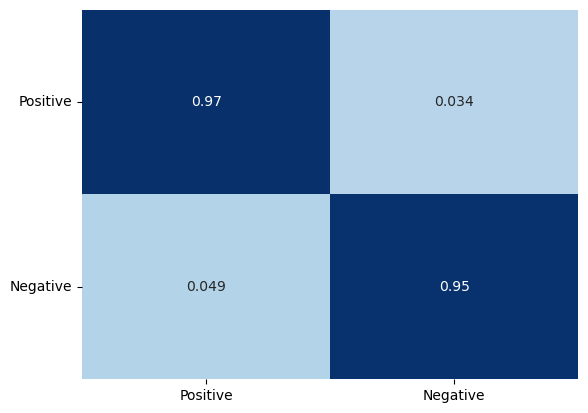

In [59]:
# cooler version :)
matrix = matrix.apply(
    lambda row: row / np.sum(row, axis=0),
    axis=1
)

# palette = sns.cubehelix_palette(as_cmap=True)
ax = sns.heatmap(
    matrix,
    annot=True, 
    cbar=False,
    center=0.3,
    cmap="Blues",
)

plt.yticks(rotation=0);

#### Decision Tree

In [60]:
X = scaled_df[selected_features] # `class` feature is not here
y = scaled_df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1502)


dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

matrix = confusion_matrix(y_test, dt.predict(X_test))
matrix = pd.DataFrame(
    matrix,
    columns=["Positive", "Negative"], # true values
    index=["Positive", "Negative"],   # predicted values
)
matrix

,Positive,Negative
Positive,57,2
Negative,2,39


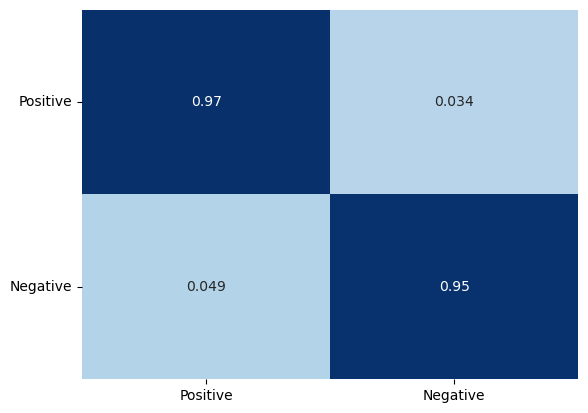

In [61]:
matrix = matrix.apply(
    lambda row: row / np.sum(row, axis=0),
    axis=1
)
ax = sns.heatmap(
    matrix,
    annot=True, 
    cbar=False,
    center=0.3,
    cmap="Blues",
)

plt.yticks(rotation=0);

#### Random Forest

for this we are going to ues `RandomizedSearchCV` !!

In [62]:

X = scaled_df[selected_features] # `class` feature is not here
y = scaled_df["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1502)

params = {
    'n_estimators': [5, 10, 20, 30, 50, 100],
    'max_depth': [2, 4, 6, 8],
    'bootstrap': [True, False],
}

rscv = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=params,
    n_iter=20,
    cv=5,
)

rscv.fit(X_train, y_train)
rscv.best_params_

{'n_estimators': 50, 'max_depth': 4, 'bootstrap': True}

In [63]:
rscv.best_score_

0.99

In [64]:
matrix = confusion_matrix(y_test, rscv.predict(X_test))
matrix = pd.DataFrame(
    matrix,
    columns=["Positive", "Negative"], # true values
    index=["Positive", "Negative"],   # predicted values
)
matrix

,Positive,Negative
Positive,58,1
Negative,2,39


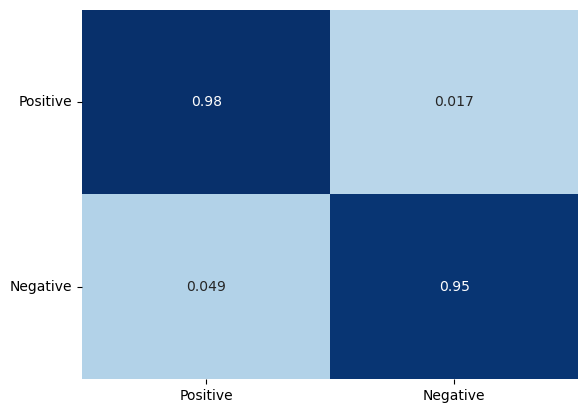

In [65]:
matrix = matrix.apply(
    lambda row: row / np.sum(row, axis=0),
    axis=1
)
ax = sns.heatmap(
    matrix,
    annot=True, 
    cbar=False,
    center=0.3,
    cmap="Blues",
)

plt.yticks(rotation=0);